In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt

In [24]:
spark = SparkSession.builder.getOrCreate()

In [25]:
Bear_Training = spark.read.csv("DataUAP/Clustering/BearTraining.csv", header=True, inferSchema=True)
Bear_Training = Bear_Training.select("Front Claws","Pupillary Distance","Ear Shape")
Bear_Training = Bear_Training.na.drop()

In [26]:
Bear_Training = Bear_Training.withColumn("Ear Shape", when(Bear_Training["Ear Shape"]=="Rounded",0). 
                               when(Bear_Training["Ear Shape"]=="Broad",1).
                               when(Bear_Training["Ear Shape"]=="Pointed",2))

In [27]:
cols = Bear_Training.columns
Bear_Training = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(Bear_Training)

In [28]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
Bear_Training = scaler.fit(Bear_Training).transform(Bear_Training)

In [29]:
Bear_Testing = spark.read.csv("DataUAP/Clustering/BearTesting.csv", header=True, inferSchema=True)
Bear_Testing = Bear_Testing.select("Front Claws","Pupillary Distance","Ear Shape", "Grizzly")
Bear_Testing = Bear_Testing.na.drop()

In [40]:
Bear_Testing = Bear_Testing.withColumn("Ear Shape", when(Bear_Testing["Ear Shape"]=="Rounded",0). 
                               when(Bear_Testing["Ear Shape"]=="Broad",1).
                               when(Bear_Testing["Ear Shape"]=="Pointed",2))

Bear_Testing = Bear_Testing.withColumn("Grizzly", when(Bear_Testing["Grizzly"]=="Yes",1).otherwise(0))

In [31]:
cols = Bear_Testing.columns
cols.remove("Grizzly")
Bear_Testing = VectorAssembler (inputCols = cols, outputCol = "Vector").transform(Bear_Testing)

In [32]:
scaler = StandardScaler(inputCol = "Vector", outputCol = "features")
Bear_Testing = scaler.fit(Bear_Testing).transform(Bear_Testing)

In [33]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(Bear_Training)

In [34]:
predictions = model.transform(Bear_Testing)

In [35]:
predictions = predictions.toPandas()

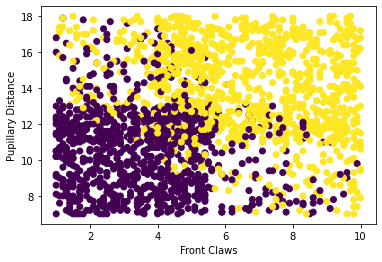

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(predictions["Front Claws"],predictions["Pupillary Distance"], c=predictions["prediction"])
ax.set_xlabel("Front Claws")
ax.set_ylabel("Pupillary Distance")
plt.show()

In [38]:
count = 0
for index, row in predictions.iterrows():
    if row["Grizzly"] == row ["prediction"]:
        count +=1

In [39]:
print("Accuracy: {}%".format(count / len(predictions) * 100))

Accuracy: 83.55%
